In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import shutil

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import pandas as pd

In [2]:
data_dir=pathlib.Path('./train_images/')
image_count = len(list(data_dir.glob('*.png')))
print(image_count)

49999


# sort file into subfolders
# je suis trop paresseux pour label manuellement
def key(word):
    return int(word[6:-4])

onlyfiles = [f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))] # files to sort
idlist = np.loadtxt('train_label.txt',dtype=str)

onlyfiles.sort(key=key)

for i in range(image_count):
    label,image = idlist[i],onlyfiles[i]
    
    destination = os.path.join('D:/OneDrive/kaggle/challenge5/train_images_sorted/',label+'/')
    shutil.copy('./train_images/'+image,destination)   

In [3]:
#load data
batch_size = 300
img_height = 32
img_width = 32

data_dir=pathlib.Path('./train_images_sorted/')

# prep training sample
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 49999 files belonging to 10 classes.
Using 40000 files for training.


In [4]:
# prep validation sample
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 49999 files belonging to 10 classes.
Using 9999 files for validation.


In [5]:
# verify classes are ok
class_names = train_ds.class_names
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [9]:
# speed up bitch
train_ds = train_ds.cache() # met dataset dans cache
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE) # prefetch du cpu vers gpu pendant training

In [10]:
# augment data
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.3),

  ]
)


In [18]:
num_classes=10

# try another model with dropout
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.BatchNormalization(),
  layers.Conv2D(64, 5, padding='same', activation=tf.keras.layers.LeakyReLU()),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 5, padding='same', activation=tf.keras.layers.LeakyReLU()),
  layers.Conv2D(32, 3, padding='same', activation=tf.keras.layers.LeakyReLU()),
  tf.keras.layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation=tf.keras.layers.LeakyReLU()),
  layers.Conv2D(64, 3, padding='same', activation=tf.keras.layers.LeakyReLU()),
  tf.keras.layers.BatchNormalization(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./checkpoint/',
    save_weights_only=True,
    save_freq='epoch')
#    monitor='val_acc',
#    mode='max',
#    save_best_only=True)


epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [model_checkpoint_callback]
)

Epoch 1/100
134/134 [==============================] - 90s 674ms/step - loss: 2.0919 - accuracy: 0.2806 - val_loss: 2.2143 - val_accuracy: 0.1887
Epoch 2/100
134/134 [==============================] - 91s 677ms/step - loss: 1.7027 - accuracy: 0.3778 - val_loss: 1.7182 - val_accuracy: 0.3426
Epoch 3/100
134/134 [==============================] - 87s 653ms/step - loss: 1.5939 - accuracy: 0.4202 - val_loss: 1.6133 - val_accuracy: 0.4044
Epoch 4/100
134/134 [==============================] - 89s 665ms/step - loss: 1.5004 - accuracy: 0.4539 - val_loss: 1.4919 - val_accuracy: 0.4617
Epoch 5/100
134/134 [==============================] - 84s 626ms/step - loss: 1.4462 - accuracy: 0.4760 - val_loss: 1.3903 - val_accuracy: 0.5019
Epoch 6/100
134/134 [==============================] - 89s 661ms/step - loss: 1.3853 - accuracy: 0.4980 - val_loss: 1.3943 - val_accuracy: 0.5098
Epoch 7/100
134/134 [==============================] - 89s 667ms/step - loss: 1.3445 - accuracy: 0.5161 - val_loss: 1.3897 -

Epoch 57/100
134/134 [==============================] - 81s 606ms/step - loss: 0.8194 - accuracy: 0.7127 - val_loss: 0.9600 - val_accuracy: 0.6921
Epoch 58/100
134/134 [==============================] - 82s 610ms/step - loss: 0.8132 - accuracy: 0.7158 - val_loss: 0.9427 - val_accuracy: 0.6904
Epoch 59/100
134/134 [==============================] - 81s 606ms/step - loss: 0.8125 - accuracy: 0.7158 - val_loss: 0.9545 - val_accuracy: 0.6952
Epoch 60/100
134/134 [==============================] - 82s 609ms/step - loss: 0.8136 - accuracy: 0.7163 - val_loss: 0.8792 - val_accuracy: 0.7074
Epoch 61/100
134/134 [==============================] - 81s 605ms/step - loss: 0.7979 - accuracy: 0.7210 - val_loss: 0.9044 - val_accuracy: 0.7008
Epoch 62/100
134/134 [==============================] - 81s 608ms/step - loss: 0.8101 - accuracy: 0.7182 - val_loss: 0.9007 - val_accuracy: 0.7016
Epoch 63/100
134/134 [==============================] - 82s 610ms/step - loss: 0.7985 - accuracy: 0.7203 - val_loss: 0

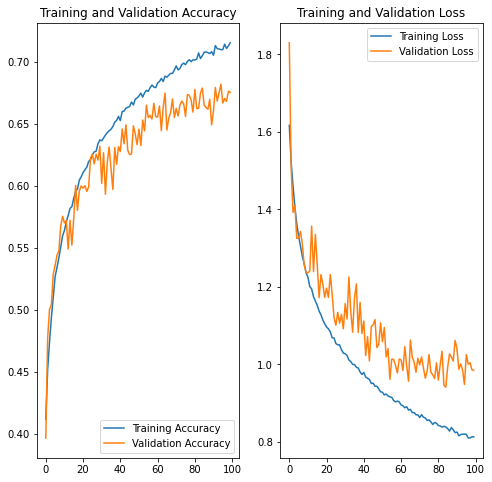

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [84]:
test_data_dir=pathlib.Path('./test_imagess/')
test_image_count = len(list(test_data_dir.glob('*.png')))
print(test_image_count)

onlyfiles = [f for f in os.listdir(test_data_dir) if os.path.isfile(os.path.join(test_data_dir, f))] # files to sort
onlyfiles.sort(key=key)

test_data_list = []
    
for i in range(test_image_count):
    filepath = './test_imagess/' + onlyfiles[i]

    img = keras.preprocessing.image.load_img(filepath, target_size=(img_height, img_width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    test_data_list.append(img_array)
        
test_data = tf.data.Dataset.from_tensor_slices(test_data_list)

10000


In [85]:
predictions = model.predict(test_data)

In [99]:
score = tf.nn.softmax(predictions)

with open('predictions.txt','w') as newfile:
    newfile.write('id,classes\n')
    for i in range(test_image_count):
        newfile.write('{},{}\n'.format(i,np.argmax(score[i])))